<h2>Twitter Sentiment Analysis</h2>
In this sentiment program, I use "Tweet Data During Indonesia Presidential Election in 2014" and try to analyst about the data. In the end, i also try to make multiclass classification (positive, negative and neutral) based on the tweet data. The following are the steps that I did
<ol>
  <li>Load the data From drive, you can also download the data in this github and open it without mount from drive</li>
  <li>Import important library</li>
  <li>Try to explore the data to know the data pattern (EDA)</li>
  <li>Preprocessing (Eliminate noise in dataset)</li>
  <ul>
    <li>Case folding (letter to lower)</li>
    <li>Cleaning (remove mention, hastag and "rt")</li>
    <li>Convert abbrevation word to its original form</li>
    <li>Delete redudant data</li>
  </ul>
  <li>Resampling data (balancing the dataset label)</li>
  <li>Split data into train and test (test_size = 0.2)</li>
  <li>Feature Extraction with TF-IDF</li>
  <li>Choose the classification model</li>
  <li>Creating the pipline, and then train the data</li>
  <li>Evaluation the model with confusion matrix and also get accuracy score</li>
  <li>Hyperparameter tuning to get the best parameter for our model</li>
</ol>

### Load Data and import the libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
HOME_DIR = '/content/drive/My Drive/Colab Notebooks/DSI Data/'

In [ ]:
# import library
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import metrics
import pickle
%matplotlib inline

### Exploratory Data Analysis

In [ ]:
df = pd.read_csv(HOME_DIR+'data/Capres2014-2.0.csv', encoding= 'unicode_escape')
df = df[['Isi_Tweet','Sentimen']]
df.head()

,Isi_Tweet,Sentimen
0,@FahrelStv Gak setuju Jokowi jadi Cawapres.. C...,1
1,"capres jokowi,wacapres abraham samad. gubernur...",1
2,"RT @RintisBautista: capres jokowi,wacapres abr...",1
3,capres ( Prabowo ) and cawapres ( jokowi ) and...,1
4,RT @Franliiiii: capres ( Prabowo ) and cawapre...,1


In [ ]:
df.columns = ['tweet', 'label']
df.head()

,tweet,label
0,@FahrelStv Gak setuju Jokowi jadi Cawapres.. C...,1
1,"capres jokowi,wacapres abraham samad. gubernur...",1
2,"RT @RintisBautista: capres jokowi,wacapres abr...",1
3,capres ( Prabowo ) and cawapres ( jokowi ) and...,1
4,RT @Franliiiii: capres ( Prabowo ) and cawapre...,1


In [ ]:
df.shape

(3356, 2)

In [ ]:
#get stopword from file
stp = open(HOME_DIR+'data/twitter_stp.dic')
stp_words = []
items = stp.readline()
while items != "":
  stp_words.append(items[:-1]) #just read word without /n
  items = stp.readline()

In [ ]:
df.label.value_counts()

 0    1467
 1    1124
-1     765
Name: label, dtype: int64

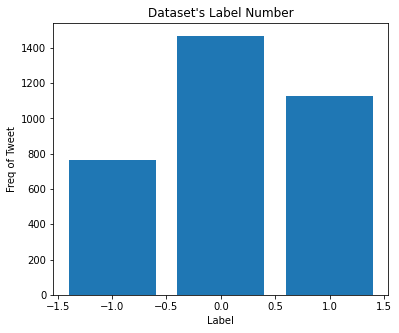

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,5))
sentiment_count = df.groupby('label').count()
plt.bar(sentiment_count.index.values, sentiment_count['tweet'])
plt.xlabel('Label')
plt.ylabel('Freq of Tweet')
plt.title('Dataset\'s Label Number')
plt.show()

In [ ]:
list_user = []
list_word = []
import re
for sentence in df['tweet']:
  for word in sentence.split():
    if '@' in word:
      mention = re.findall('\w*(@\w+)',word.lower())
      list_user += mention
    else:
      if word != '':
        list_word.append(re.sub('[^A-Za-z0-9]+', '', word.lower()))

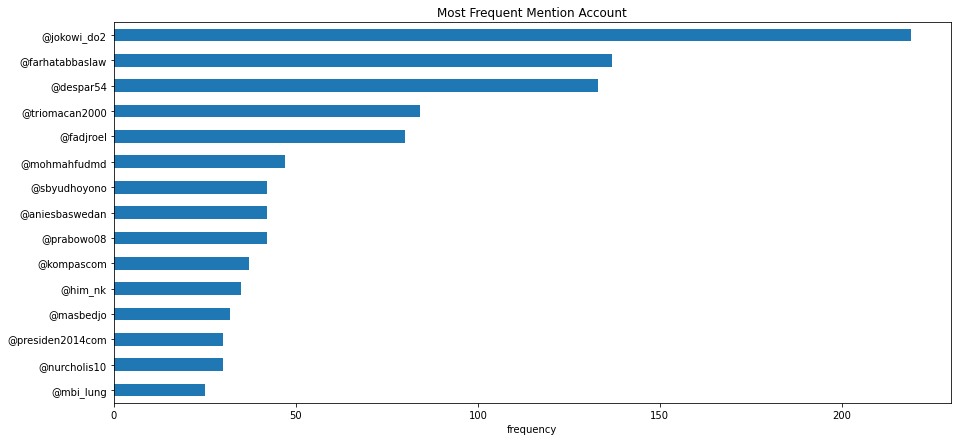

In [ ]:
mention_data = pd.DataFrame({'username' : list_user})['username'].value_counts()
mention_data.head(15).sort_values(ascending=True).plot(kind='barh',figsize=(15,7),title='Most Frequent Mention Account')
plt.xlabel('frequency')
plt.show()

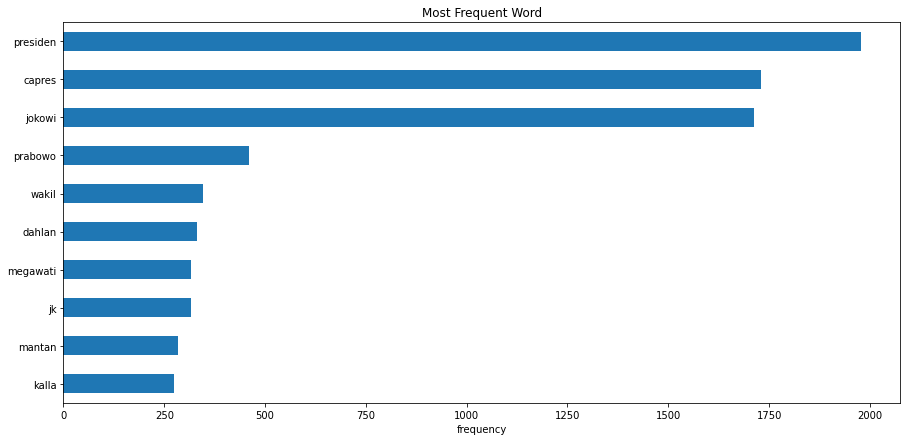

In [ ]:
word_count = []
for word in list_word:
  if word not in stp_words and word != '':
    word_count.append(word)
word_data = pd.DataFrame({'word': word_count})['word'].value_counts()
word_data.head(10).sort_values(ascending=True).plot(kind='barh',figsize=(15,7),title='Most Frequent Word')
plt.xlabel('frequency')
plt.show()

### Preprocessing

In [ ]:
# df = df.reset_index()
df_tweet, df_label = df['tweet'], df['label']

In [ ]:
#get obbreviation and orginal word from file and save it in directory
abbreviation = open(HOME_DIR+'data/singkatankata.dic')
dict_abb = {}
items = abbreviation.readline()
while items != "":
  word = re.split('\s',items)
  dict_abb[word[0]]=word[1]
  items = abbreviation.readline()

In [ ]:
#find word in list key dict
def checkKey(dict, key): 
    if key in dict.keys(): 
        return True
    return False

In [ ]:
#remove mention, rt, hastag and convert abbrevation word to its original form.
data_tweet = []
for i in range(0,len(df_tweet)):
  casefold = df_tweet[i].lower()
  cleaning_mention = re.sub('\w*(@\w+)','',casefold)
  cleaning_rt = re.sub("rt",'',cleaning_mention)
  cleaning_hashtag = re.sub("#\w+",'',cleaning_rt)

  # convert abbreviation word to the original form
  words = re.findall(r'\S[a-z0-9]+', cleaning_rt)
  sentence = ""
  for word in words:
    if checkKey(dict_abb, word):
      sentence += dict_abb[word]+" "
    else:
      sentence += word+" "
  data_tweet.append(sentence)

In [ ]:
# #delete redudance sentence
# not_rendundant_tweet = []
# not_rendundant_label = []
# for idx, sentence in enumerate (data_tweet):
#   if sentence not in not_rendundant_tweet:
#     not_rendundant_tweet.append(sentence)
#     not_rendundant_label.append(df_label[idx])
# len(not_rendundant_tweet)

2695

In [ ]:
# df = pd.DataFrame(list(zip(not_rendundant_tweet, not_rendundant_label)), columns =['tweet', 'label'])
df = pd.DataFrame(list(zip(data_tweet, df['label'])), columns =['tweet', 'label']) 
df.label.value_counts()

 0    1467
 1    1124
-1     765
Name: label, dtype: int64

### Resampling

In [ ]:
from sklearn.utils import resample
#Just make use resampling method for imbalance data
fraud0 = df[df['label'] == 0]
fraud1 = df[df['label'] == 1]
not_fraud = df[df['label'] == -1]

# upsample minority
fraud_upsampled0 = resample(fraud0,
                          replace=True, # sample with replacement
                          n_samples=len(fraud1), # match number in majority class
                          random_state=27) # reproducible results
# fraud_upsampled1 = resample(fraud1,
#                           replace=True, # sample with replacement
#                           n_samples=len(not_fraud), # match number in majority class
#                           random_state=27) # reproducible results

# combine majority and upsampled minority
df = pd.concat([not_fraud, fraud_upsampled0, fraud1])

# check new class counts
df.label.value_counts()

 1    1124
 0    1124
-1     765
Name: label, dtype: int64

### Build Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size = 0.2, random_state=50)

In [ ]:
vect = TfidfVectorizer(min_df=0, max_df=0.505, stop_words=stp_words,
                      token_pattern = '\\b[a-zA-Z][a-zA-Z][a-zA-Z]+\\b')

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=160, 
                                criterion= 'entropy',
                                min_samples_split=3, #2
                                min_samples_leaf=1, #1
                                min_weight_fraction_leaf=0, #0
                                class_weight=None, #None, balanced
                                max_features="log2"
                                )

pipeline = Pipeline([
                    ('vect',vect),
                    ('clf',model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['olah', 'rasa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.8043117744610282


In [ ]:
#Confussion Matrix
print(classification_report(y_pred, y_test))

In [ ]:
new_tweet = ["goblok sekali orang itu, main hakim sendiri dan tak punya malu",
             "Dia sangat pandai dan keren. Baik sekali dia itu"]
pipeline.predict(new_tweet)

array([-1,  1])

In [ ]:
# dump pipeline to pickle
pickle.dump(pipeline,open(HOME_DIR+'sentiment_tweet_presiden.pkl', 'wb'))

### Hyperparameter tuning

In [ ]:
#grid search cv
from sklearn.model_selection import GridSearchCV

#karenda didalam clf, kasih clf untuk identifier
params = {'vect__min_df':[0,0.05,0.1],
          'vect__max_df':[0.85, 0.9, 0.95],
          'clf__min_samples_leaf':[1,2,3],
          'clf__min_samples_split':[2,3,4,5],
          'clf__min_weight_fraction_leaf':[0.0,0.04,0.07],
          'clf__n_estimators':[115,125,135],
          'clf__criterion':['gini','entropy'],
          'clf__class_weight':['None','balanced'],
          'max_features':['auto', 'sqrt', 'log2']}

In [ ]:
grid = GridSearchCV(pipeline,
                    params,
                    n_jobs = 10,
                    cv=5)

In [ ]:
grid.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
grid.best_estimator_
#use the best parameter on our model